<a href="https://colab.research.google.com/github/Devphadatare/CBTCIP/blob/main/Spam_email_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Spam Email Detection**

Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import nltk
from nltk.corpus import stopwords
import string
import os

# Ensure nltk stopwords are downloaded
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Load the Dataset

In [2]:
# Load dataset
file_path = 'Spam_email_detection.csv'  # Update this path to your CSV file location
if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
    exit()

data = pd.read_csv(file_path)

# Display the column names to verify
print("Column names in the dataset:", data.columns.tolist())

# Check the first few rows to understand the structure
print(data.head())

# Assuming the expected column names are 'v1' for label and 'v2' for message
expected_columns = ['v1', 'v2']
if not all(column in data.columns for column in expected_columns):
    print(f"Expected columns {expected_columns} not found in the dataset.")
    exit()


Column names in the dataset: ['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


Data Preprocessing

In [3]:
# Define stopwords
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    if isinstance(text, str):
        # Remove punctuation
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Convert to lowercase
        text = text.lower()
        # Remove stopwords, but keep the words if it's the only content
        text = ' '.join(word for word in text.split() if word not in stop_words or len(text.split()) == 1)
    else:
        text = ''
    return text

# Apply preprocessing to the 'v2' column (message)
data['v2'] = data['v2'].apply(preprocess_text)


Feature Extraction with TF-IDF Vectorizer

In [4]:
# Feature Extraction with TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7)

# Transform the text data to TF-IDF features
try:
    X = tfidf.fit_transform(data['v2']).toarray()
    if not tfidf.vocabulary_:
        raise ValueError("Empty vocabulary. Perhaps the documents only contain stop words.")
except ValueError as e:
    print(f"ValueError: {e}")
    exit()


Define Labels and Split data

In [5]:
# Convert labels to binary
y = data['v1'].apply(lambda x: 1 if x == 'spam' else 0)

# Ensure consistency between X and y
if X.shape[0] != y.shape[0]:
    print("Inconsistent number of samples between X and y. Please check your data preprocessing steps.")
    exit()

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Training the Model

In [6]:
# Initialize the classifier
model = MultinomialNB()

# Train the model
model.fit(X_train, y_train)


MultinomialNB()

Model Evaluation

In [7]:
# Predict on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Get confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Get classification report
class_report = classification_report(y_test, y_pred, target_names=['ham', 'spam'], output_dict=True)

# Print results
print("\n---------------------------------------------")
print("Classification Report:")
print("---------------------------------------------")
for label in ['ham', 'spam']:
    print(f"Class '{label}' Report:")
    print(f"Precision: {class_report[label]['precision']:.2f}")
    print(f"Recall: {class_report[label]['recall']:.2f}")
    print(f"F1-Score: {class_report[label]['f1-score']:.2f}")
    print(f"Support: {class_report[label]['support']}")
    print()

print("---------------------------------------------")
print("Overall Report:")
print("---------------------------------------------")
print(f"Accuracy: {accuracy:.2f}")
print(f"\nConfusion Matrix:\n{conf_matrix}")


Accuracy: 0.98

---------------------------------------------
Classification Report:
---------------------------------------------
Class 'ham' Report:
Precision: 0.97
Recall: 1.00
F1-Score: 0.99
Support: 965

Class 'spam' Report:
Precision: 1.00
Recall: 0.83
F1-Score: 0.91
Support: 150

---------------------------------------------
Overall Report:
---------------------------------------------
Accuracy: 0.98

Confusion Matrix:
[[965   0]
 [ 25 125]]


Model Visualization

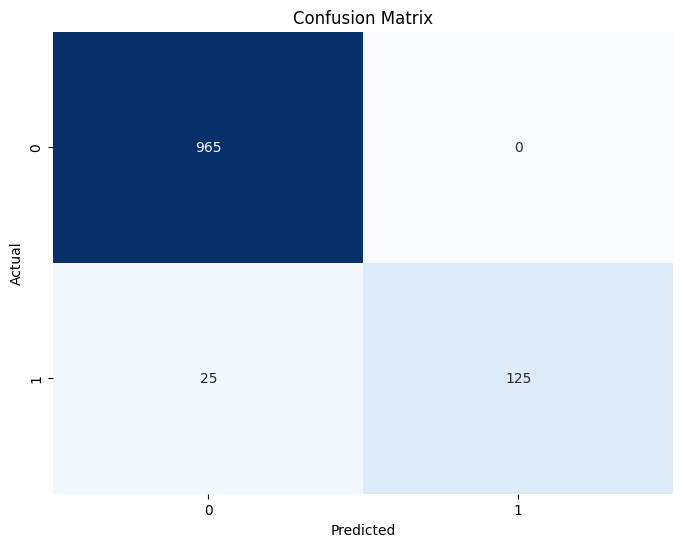

In [8]:
# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


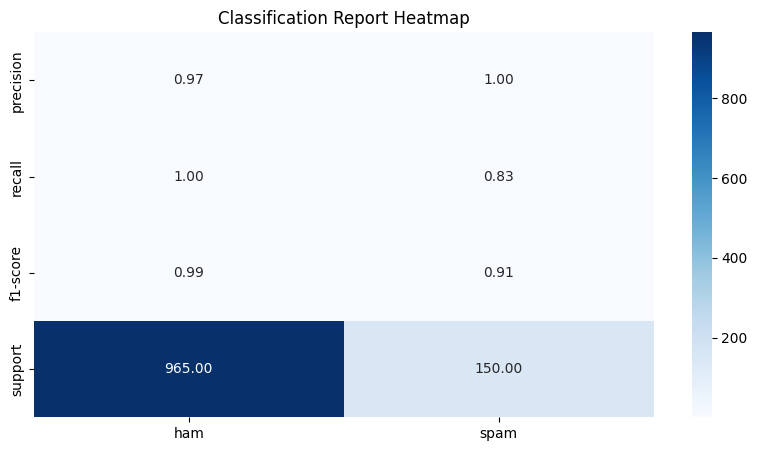

In [9]:
# Visualizing the Classification Report
df_class_report = pd.DataFrame(class_report).transpose()

plt.figure(figsize=(10, 5))
sns.heatmap(df_class_report.iloc[:-3, :].T, annot=True, cmap='Blues', fmt=".2f", cbar=True)
plt.title('Classification Report Heatmap')
plt.show()

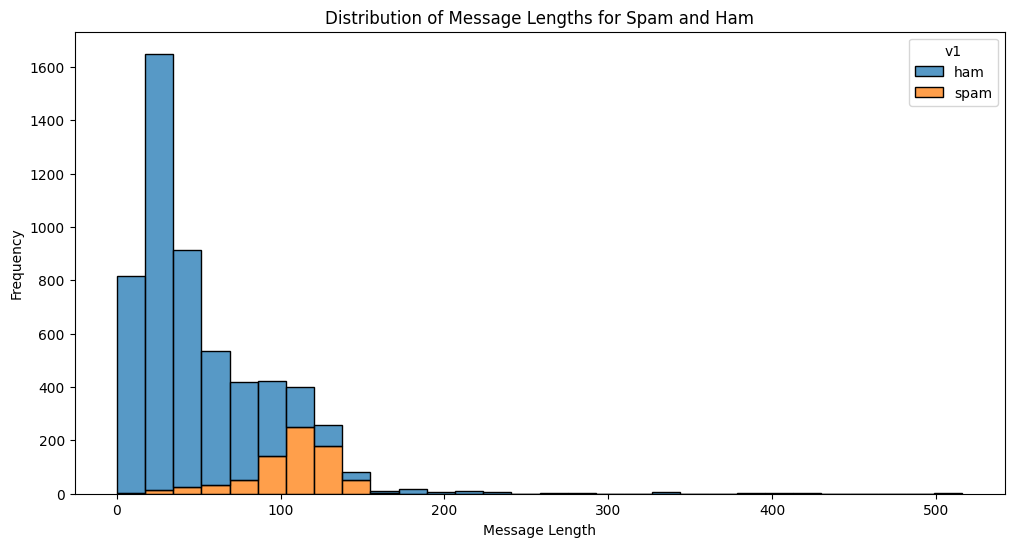

In [10]:
# Add a new column for message length
data['message_length'] = data['v2'].apply(len)

# Plot the distribution of message lengths for spam and ham
plt.figure(figsize=(12, 6))
sns.histplot(data=data, x='message_length', hue='v1', multiple='stack', bins=30)
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.title('Distribution of Message Lengths for Spam and Ham')
plt.show()


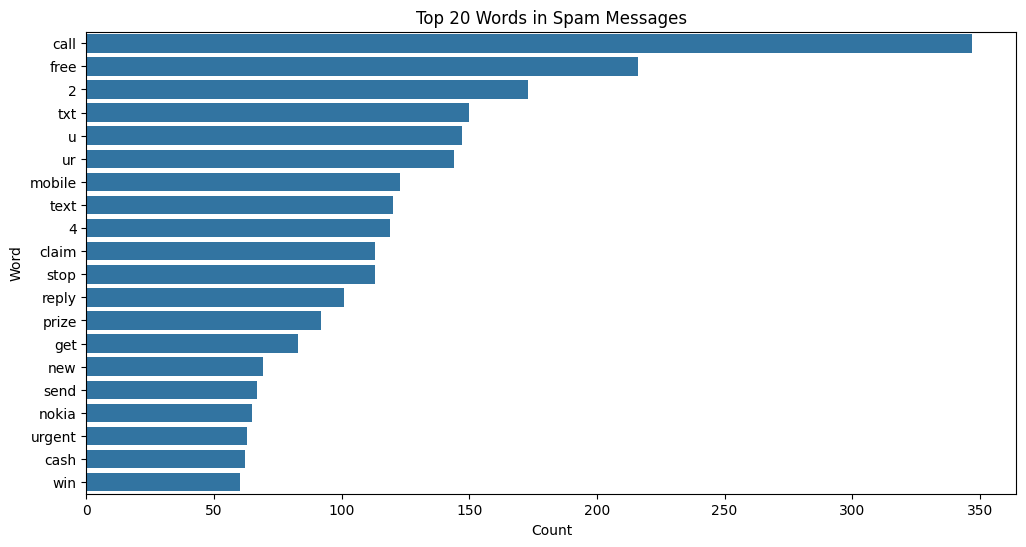

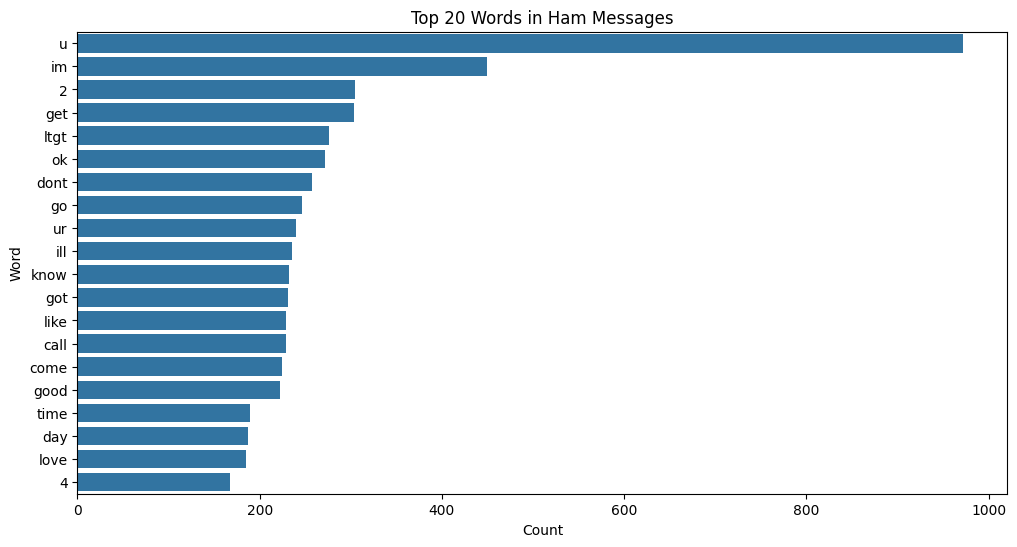

In [11]:
from collections import Counter

# Get the top 20 words for spam and ham messages
spam_words = ' '.join(list(data[data['v1'] == 'spam']['v2']))
ham_words = ' '.join(list(data[data['v1'] == 'ham']['v2']))

spam_word_count = Counter(spam_words.split()).most_common(20)
ham_word_count = Counter(ham_words.split()).most_common(20)

# Create DataFrame for visualization
spam_df = pd.DataFrame(spam_word_count, columns=['Word', 'Count'])
ham_df = pd.DataFrame(ham_word_count, columns=['Word', 'Count'])

# Plot the top 20 words for spam messages
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=spam_df)
plt.title('Top 20 Words in Spam Messages')
plt.show()

# Plot the top 20 words for ham messages
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Word', data=ham_df)
plt.title('Top 20 Words in Ham Messages')
plt.show()


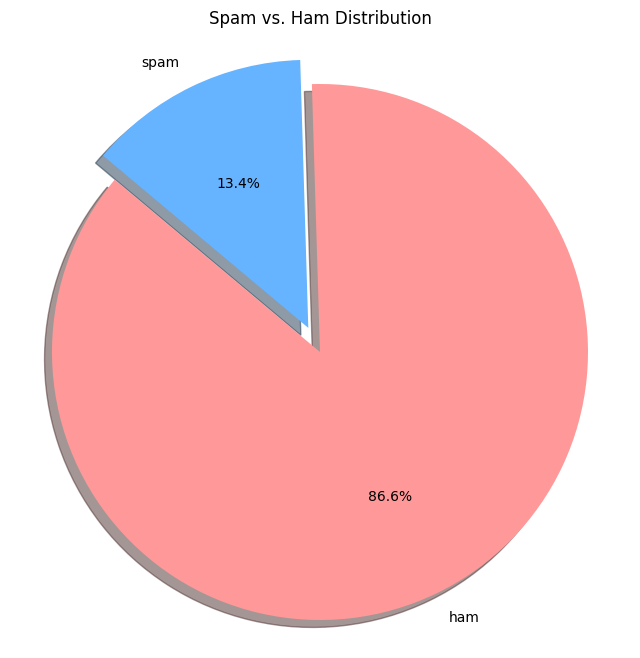

In [12]:
plt.figure(figsize=(8, 8))
labels = data['v1'].value_counts().index
sizes = data['v1'].value_counts().values
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)  # explode the first slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Spam vs. Ham Distribution')
plt.show()
